In [18]:
import os
import copy
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    load_circuit,
    load_qasm_circuit,
    create_dir,
    get_random_state
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from experiments.create_state import get_state
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime
from typing import Tuple
from qiskit_aer import Aer

%matplotlib inline

In [19]:
results_dir = "results/runs_shell/distributions"
run_range = list(range(1, 11))
#qubit_range = [3, 4, 5, 6, 7, 8]
qubit_range = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# EPS values are mapped separately
#eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
eps_values = [0.5, 0.1, 0.05, 0.01]

In [20]:
def load_results(results_dir, state_type, qubit_range, eps_values) -> Tuple[dict,dict]:
    #[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
    original_results_dict = {
        "num_qubits": [],
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }

    modified_results_dict = copy.deepcopy(original_results_dict)

    for (r_dir, st_type, num_qubits, eps) in product([results_dir], [state_type], qubit_range, eps_values):
        if not num_qubits in original_results_dict["num_qubits"]: 
            original_results_dict["num_qubits"] += [num_qubits]
            modified_results_dict["num_qubits"] += [num_qubits]

        original_results_dict[eps] += [[]]
        modified_results_dict[eps] += [[]]

        for run_idx in run_range:
            fid_loss_original = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
            original_results_dict[eps][-1] += [data_original.round(4)]

            fid_loss_modified = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
            data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
            modified_results_dict[eps][-1]+= [data_modified.round(4)]
    
    return original_results_dict, modified_results_dict


def compute_statistics(results_dict: dict) -> Tuple[dict, dict]: 
    default_dict = {
        "num_qubits": qubit_range,
        0.5: [],
        0.1: [],
        0.05: [],
        0.01: [],
    }
    mean_results_dict = copy.deepcopy(default_dict)
    stds_results_dict = copy.deepcopy(default_dict)

    #stds_original_results_dict = copy.deepcopy(default_dict)
    #stds_modified_results_dict = copy.deepcopy(default_dict)

    for eps in eps_values:
        mean_results_dict[eps] = np.mean(results_dict[eps], axis=1)
        stds_results_dict[eps] = np.std(results_dict[eps], axis=1).round(2)

        #mean_modified_results_dict[eps] = np.mean(modified_results_dict[eps], axis=1)
        #stds_modified_results_dict[eps] = np.std(modified_results_dict[eps], axis=1).round(2)
    return mean_results_dict, stds_results_dict


def to_dataframe(results_dict: dict) -> pd.DataFrame:
    df_results = pd.DataFrame(results_dict)
    df_results = df_results.set_index("num_qubits")
    return df_results

def get_state_vector(quantum_circuit):
    sv_sim = Aer.get_backend("statevector_simulator")
    job = sv_sim.run(quantum_circuit)
    result = job.result()
    state_vector = result.get_statevector()
    return state_vector.data

def get_loaded_states(results_dir, state_type, execution_range, n_qubits, eps_value) -> Tuple[np.ndarray, np.ndarray]:

    sv_list_original = []
    sv_list_modified = []

    for n_run in range(1, execution_range+1):
        # original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        # original_circuit = load_circuit(original_circuit_file_name)
        original_circuit_file_name = os.path.join(results_dir, state_type, f"run_{n_run}", "circuits", f"original_curcuit_{n_qubits}qb_{eps_value}eps.qasm")
        original_circuit = load_qasm_circuit(original_circuit_file_name)

        # Because we are now loading qasm circuits we do not need to assign all parameters
        # parameters_original_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"original_xbest_{n_qubits}qb_{eps_value}eps.csv")
        # parameters_original = np.loadtxt(parameters_original_filename, delimiter=",")


        # modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.pkl")
        # modified_circuit = load_circuit(modified_circuit_file_name)
        modified_circuit_file_name = os.path.join(results_dir, state_type, "run_10", "circuits", f"modified_curcuit_{n_qubits}qb_{eps_value}eps.qasm")
        modified_circuit = load_qasm_circuit(modified_circuit_file_name)

        # Because we are now loading qasm circuits we do not need to assign all parameters
        # parameters_modified_filename = os.path.join(results_dir, state_type, f"run_{n_run}", "csv", f"modified_xbest_{n_qubits}qb_{eps_value}eps.csv")
        # parameters_modified = np.loadtxt(parameters_modified_filename, delimiter=",")

        # p_original_circuit = original_circuit.assign_parameters(parameters_original)
        # sv_original = get_state_vector(p_original_circuit)
        sv_original = get_state_vector(original_circuit)
        sv_list_original += [sv_original]

        # p_modified_circuit = modified_circuit.assign_parameters(parameters_modified)
        # sv_modified = get_state_vector(p_modified_circuit)
        sv_modified = get_state_vector(modified_circuit)
        sv_list_modified += [sv_modified]

    sv_mean_original = np.mean(sv_list_original, axis=0)
    sv_mean_modified = np.mean(sv_list_modified, axis=0)

    return sv_mean_original, sv_mean_modified

### Normal distribution $(\mu = 0.5, \sigma = 0.3)$

In [21]:
state_type = "normal"

In [22]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [23]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02650,0.02650,0.87405,0.85894
4,0.02770,0.02770,0.00560,0.95638
5,0.02670,0.02670,0.00650,0.02354
6,0.03889,0.02590,0.00724,0.00361
7,0.02550,0.02550,0.00641,0.01586
8,0.02520,0.02520,0.00964,0.00612
9,0.02510,0.02510,0.00640,0.00339
10,0.02510,0.02510,0.00640,0.01359
11,0.02500,0.12249,0.00633,0.00569


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.02650,0.02650,0.80964,0.88454
4,0.02750,0.02750,0.00560,0.91920
5,0.02650,0.02650,0.75030,0.00262
6,0.02580,0.02580,0.00650,0.75015
7,0.02530,0.02530,0.50320,0.00378
8,0.02510,0.02510,0.00640,0.00227
9,0.02500,0.02500,0.10576,0.00546
10,0.02490,0.02490,0.00630,0.77602
11,0.02490,0.02490,0.75160,0.00204


In [24]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,True
4,False,False,False,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,False,False
9,False,False,True,True
10,False,False,False,True
11,False,False,True,False


In [25]:
n_qubits = 15
eps_value = 0.05
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

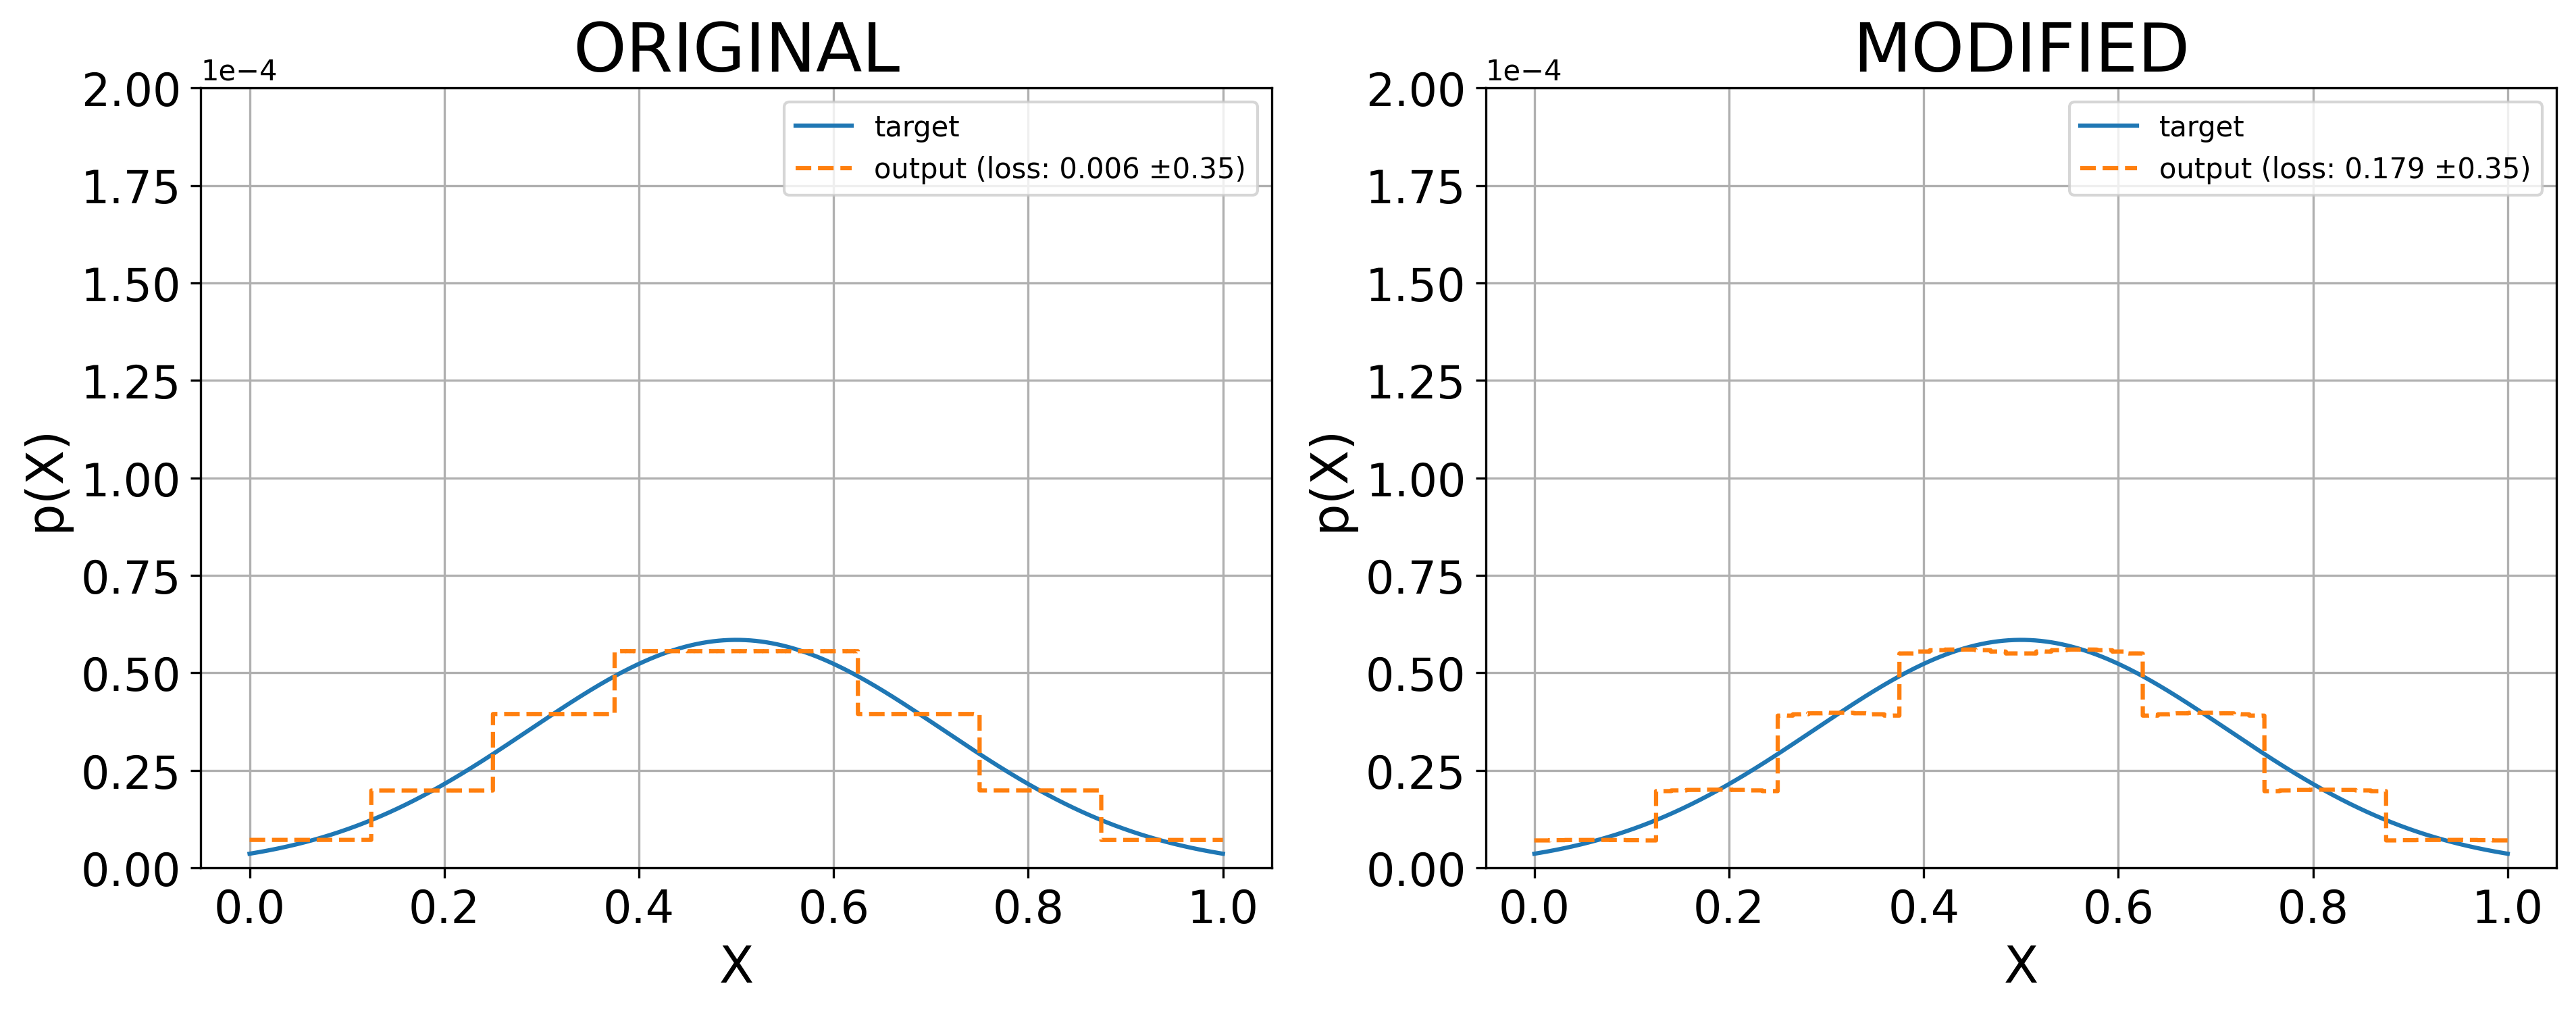

In [26]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### $log$-Normal Distribution $(s= 1, \mu = 0.1, \sigma = 0.3)$

In [27]:
state_type = "lognormal"

In [28]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [29]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15460,0.15460,0.87671,0.84479
4,0.21620,0.21620,0.04265,0.93971
5,0.22560,0.22560,0.03878,0.01965
6,0.22200,0.22200,0.03453,0.03501
7,0.21910,0.21910,0.03088,0.01911
8,0.21750,0.21750,0.02734,0.01619
9,0.21670,0.21670,0.02993,0.01813
10,0.21620,0.21620,0.02869,0.01776
11,0.21600,0.37272,0.02631,0.03413


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15460,0.15460,0.90451,0.70264
4,0.21110,0.21110,0.04016,0.96819
5,0.22210,0.22210,0.77222,0.01813
6,0.21940,0.21940,0.02951,0.75555
7,0.21710,0.21710,0.51491,0.01629
8,0.21570,0.21570,0.03092,0.01559
9,0.21500,0.21500,0.12293,0.01874
10,0.21460,0.21460,0.13848,0.75436
11,0.21440,0.21440,0.75622,0.03679


In [30]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,True,False
4,False,False,False,True
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,True,False
9,False,False,True,True
10,False,False,True,True
11,False,False,True,True


In [31]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

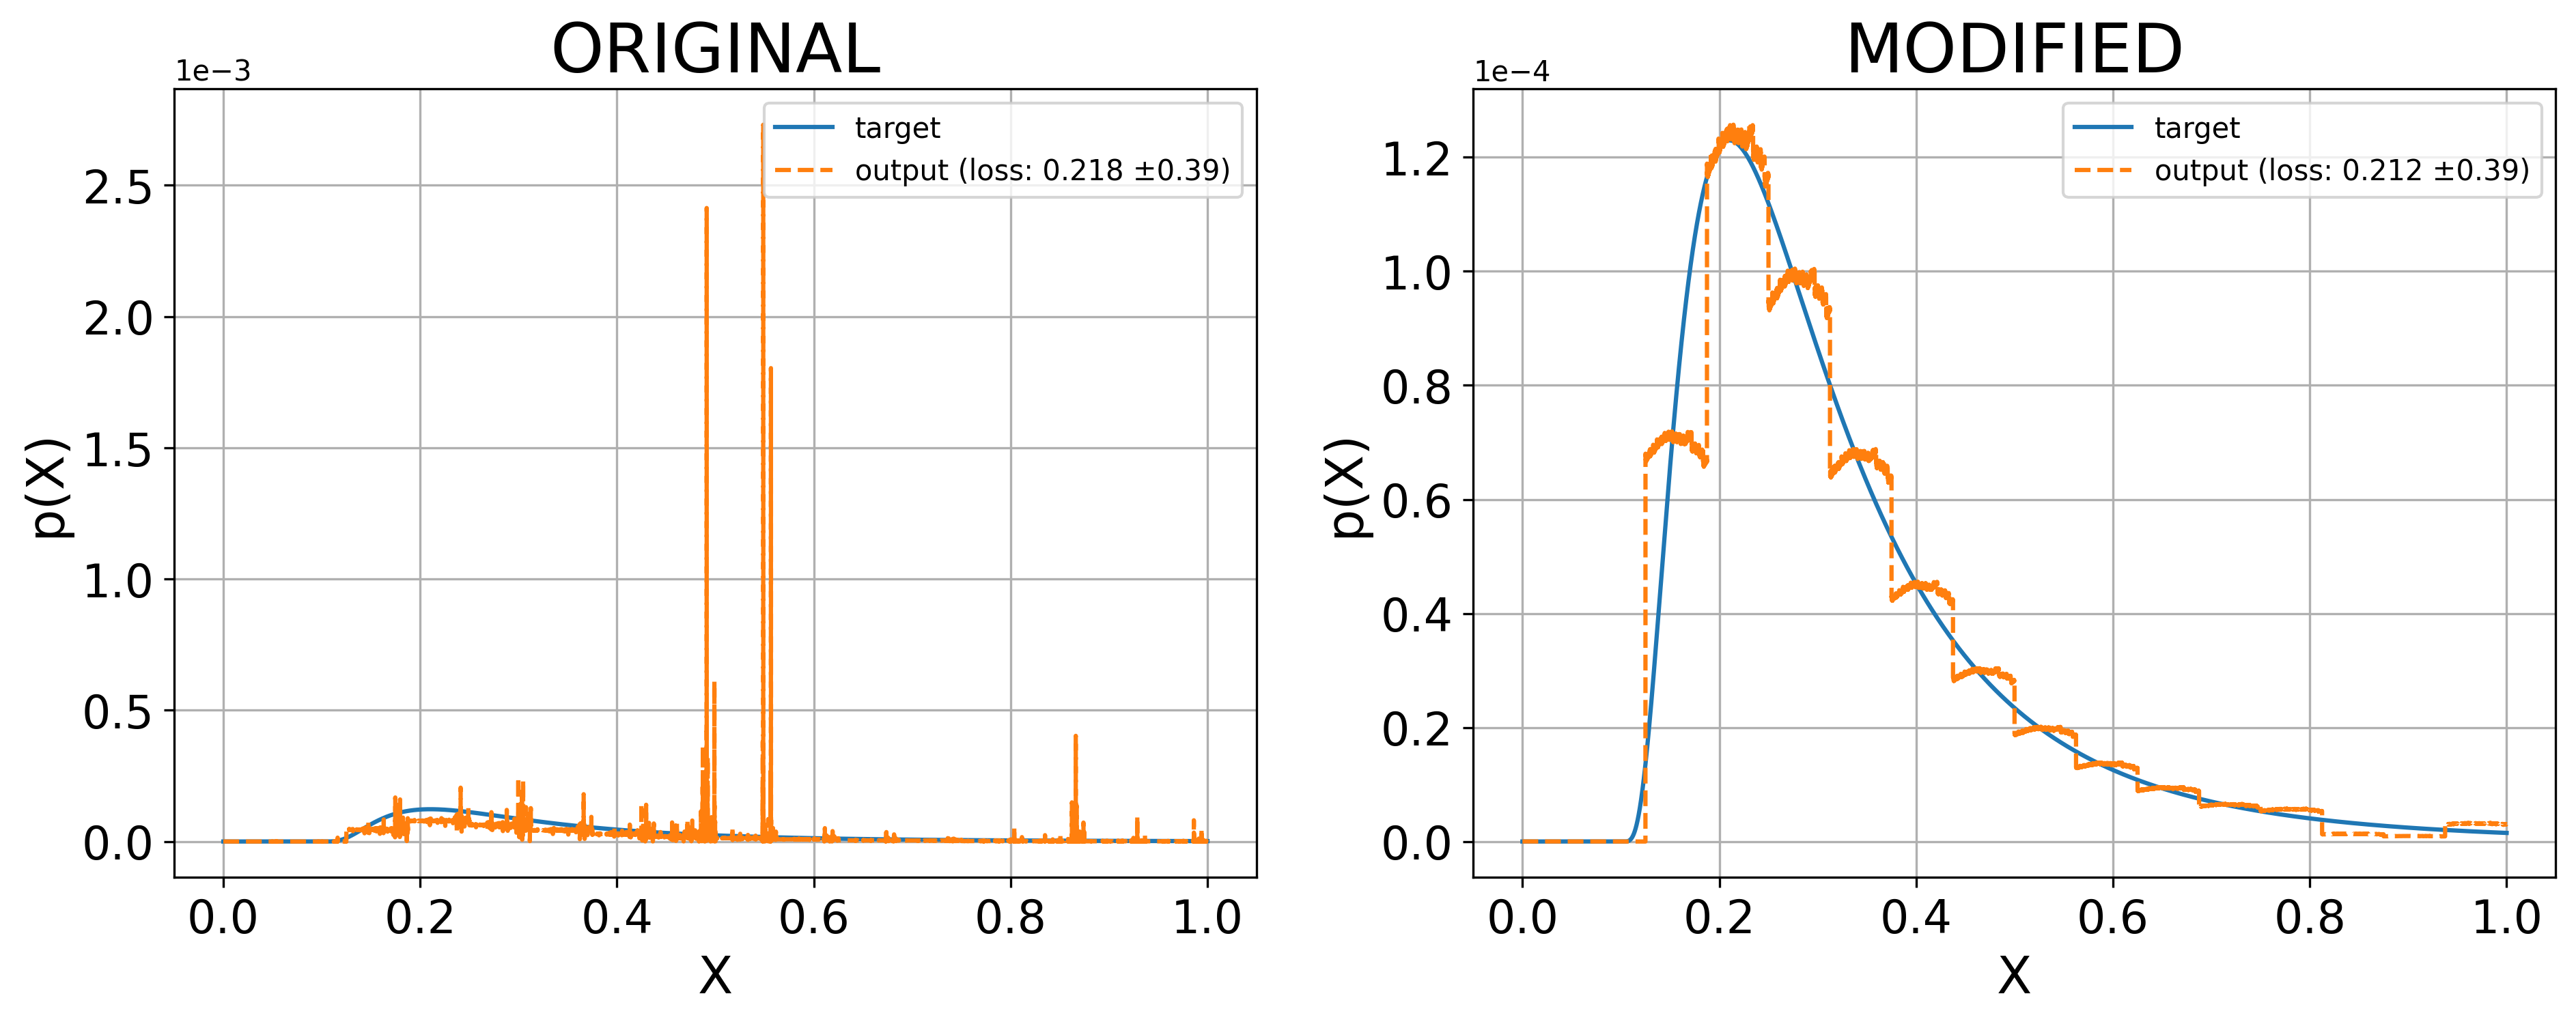

In [32]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "s": 1, "loc": 0.1, "scale": 0.3})


x_points = np.linspace(0, 1, 2**n_qubits)


target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
#axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
#axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### Bimodal Distribution $(\mu_1 = 0.25, \sigma_1 = 0.1; \mu_2 = 0.75, \sigma_2 = 0.15)$

In [35]:
state_type = "bimodal"

In [36]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [37]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15370,0.15370,0.88307,0.84787
4,0.19370,0.19370,0.03350,0.96695
5,0.19410,0.19410,0.03790,0.01788
6,0.19150,0.19150,0.03820,0.01589
7,0.18960,0.18960,0.03802,0.01349
8,0.18850,0.18850,0.03781,0.01490
9,0.18800,0.18800,0.03770,0.01697
10,0.18770,0.26893,0.13430,0.01778
11,0.18750,0.18750,0.03760,0.01832


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.15370,0.15370,0.92845,0.81748
4,0.19250,0.19250,0.03351,0.94832
5,0.19300,0.19300,0.75150,0.01342
6,0.19050,0.19050,0.03805,0.75248
7,0.18870,0.18870,0.51904,0.01929
8,0.18770,0.18770,0.03760,0.03329
9,0.18720,0.18720,0.03745,0.01335
10,0.18690,0.18690,0.09335,0.75284
11,0.18680,0.18708,0.76568,0.02487


In [38]:
display(df_stds_original)
display(df_stds_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00,0.00,0.08,0.16
4,0.00,0.00,0.00,0.05
5,0.00,0.00,0.00,0.01
6,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.02
8,0.00,0.00,0.00,0.05
9,0.00,0.00,0.00,0.01
10,0.00,0.00,0.17,0.00
11,0.00,0.00,0.02,0.04


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.00,0.00,0.08,0.16
4,0.00,0.00,0.00,0.05
5,0.00,0.00,0.00,0.01
6,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.02
8,0.00,0.00,0.00,0.05
9,0.00,0.00,0.00,0.01
10,0.00,0.00,0.17,0.00
11,0.00,0.00,0.02,0.04


In [39]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,True,False
4,False,False,True,False
5,False,False,True,False
6,False,False,False,True
7,False,False,True,True
8,False,False,False,True
9,False,False,False,False
10,False,False,False,True
11,False,False,True,True


In [41]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

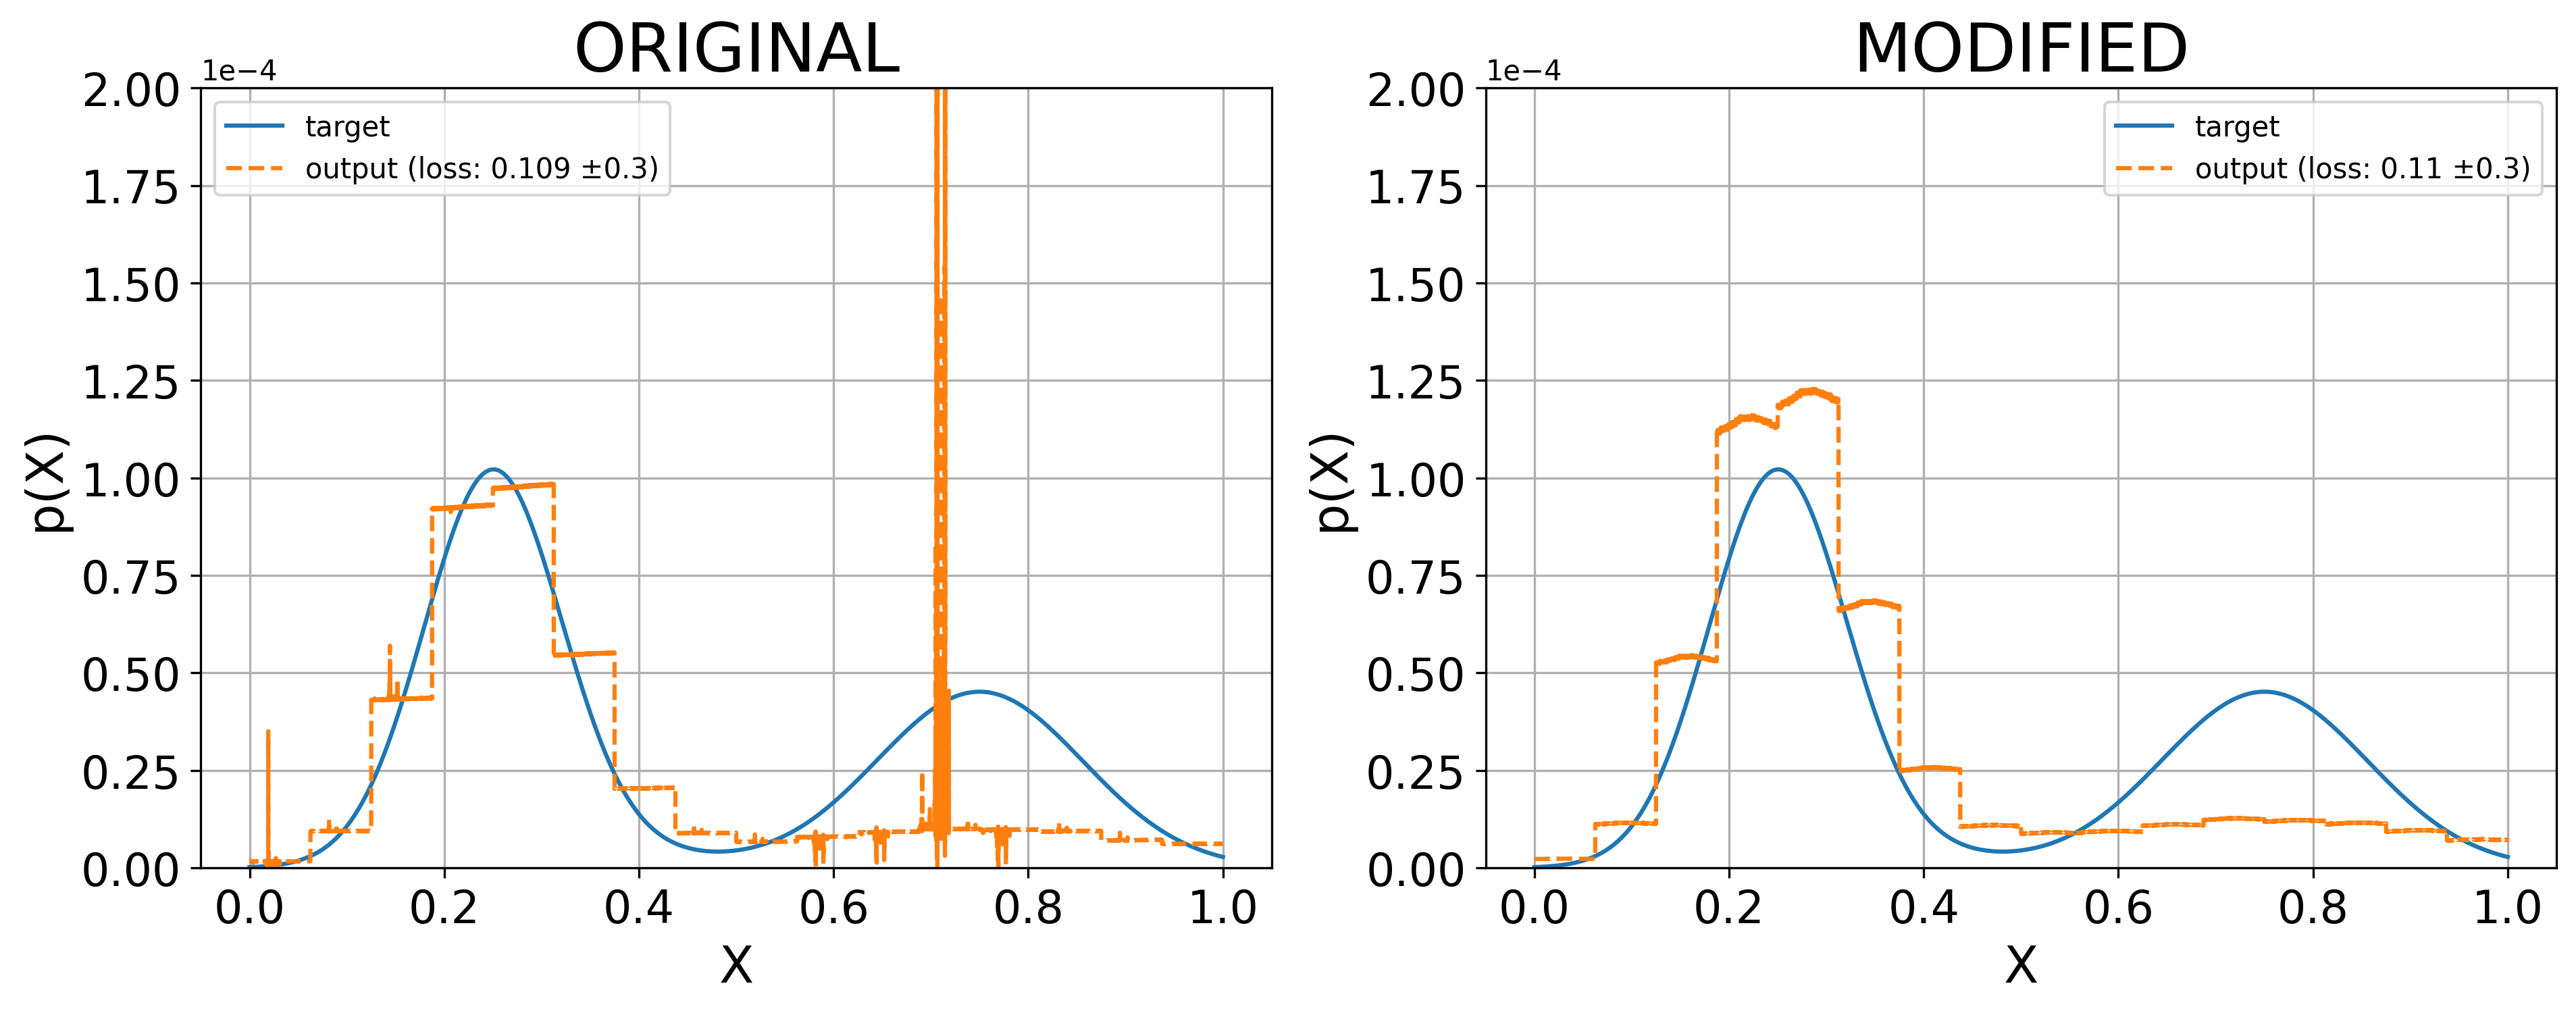

In [42]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc_bim1": 0.25, "scale_bim1": 0.1, "loc_bim2": 0.75, "scale_bim2": 0.15})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")

### Laplace $(\mu = 0.5, \sigma = 0.2)$

In [43]:
state_type = "laplace"

In [44]:
original_results_dict, modified_results_dict = load_results(results_dir, state_type, qubit_range, eps_values)

mean_original_results_dict, stds_original_results_dict = compute_statistics(original_results_dict)
mean_modified_results_dict, stds_modified_results_dict = compute_statistics(modified_results_dict)

df_mean_original = to_dataframe(mean_original_results_dict)
df_stds_original = to_dataframe(stds_modified_results_dict)

df_mean_modified = to_dataframe(mean_modified_results_dict)
df_stds_modified = to_dataframe(stds_modified_results_dict)

In [45]:
display(df_mean_original)
display(df_mean_modified)

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.10510,0.10510,0.96603,0.82202
4,0.11770,0.11770,0.02704,0.94237
5,0.11710,0.11710,0.03511,0.01543
6,0.11530,0.11530,0.03266,0.01632
7,0.11410,0.11410,0.03597,0.01981
8,0.11340,0.11340,0.03173,0.01652
9,0.11300,0.11300,0.03195,0.02100
10,0.11280,0.11280,0.03159,0.01273
11,0.11270,0.11270,0.12964,0.10933


,0.5,0.1,0.05,0.01
num_qubits,,,,
3,0.10510,0.10510,0.82961,0.78701
4,0.11530,0.11530,0.02812,0.97367
5,0.11490,0.11490,0.73767,0.00860
6,0.11320,0.11320,0.03258,0.74900
7,0.11200,0.11200,0.51570,0.01791
8,0.11140,0.11140,0.03330,0.01320
9,0.19990,0.11100,0.03148,0.11054
10,0.19969,0.11090,0.12808,0.75328
11,0.19969,0.11080,0.76662,0.01350


In [46]:
df_mean_original < df_mean_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
3,False,False,False,False
4,False,False,True,True
5,False,False,True,False
6,False,False,False,True
7,False,False,True,False
8,False,False,True,False
9,True,False,False,True
10,True,False,True,True
11,True,False,True,False


In [47]:
n_qubits = 15
eps_value = 0.01
execution_range = 10

sv_mean_original, sv_mean_modified = get_loaded_states(results_dir=results_dir, state_type=state_type, execution_range=execution_range, n_qubits=n_qubits, eps_value=eps_value)

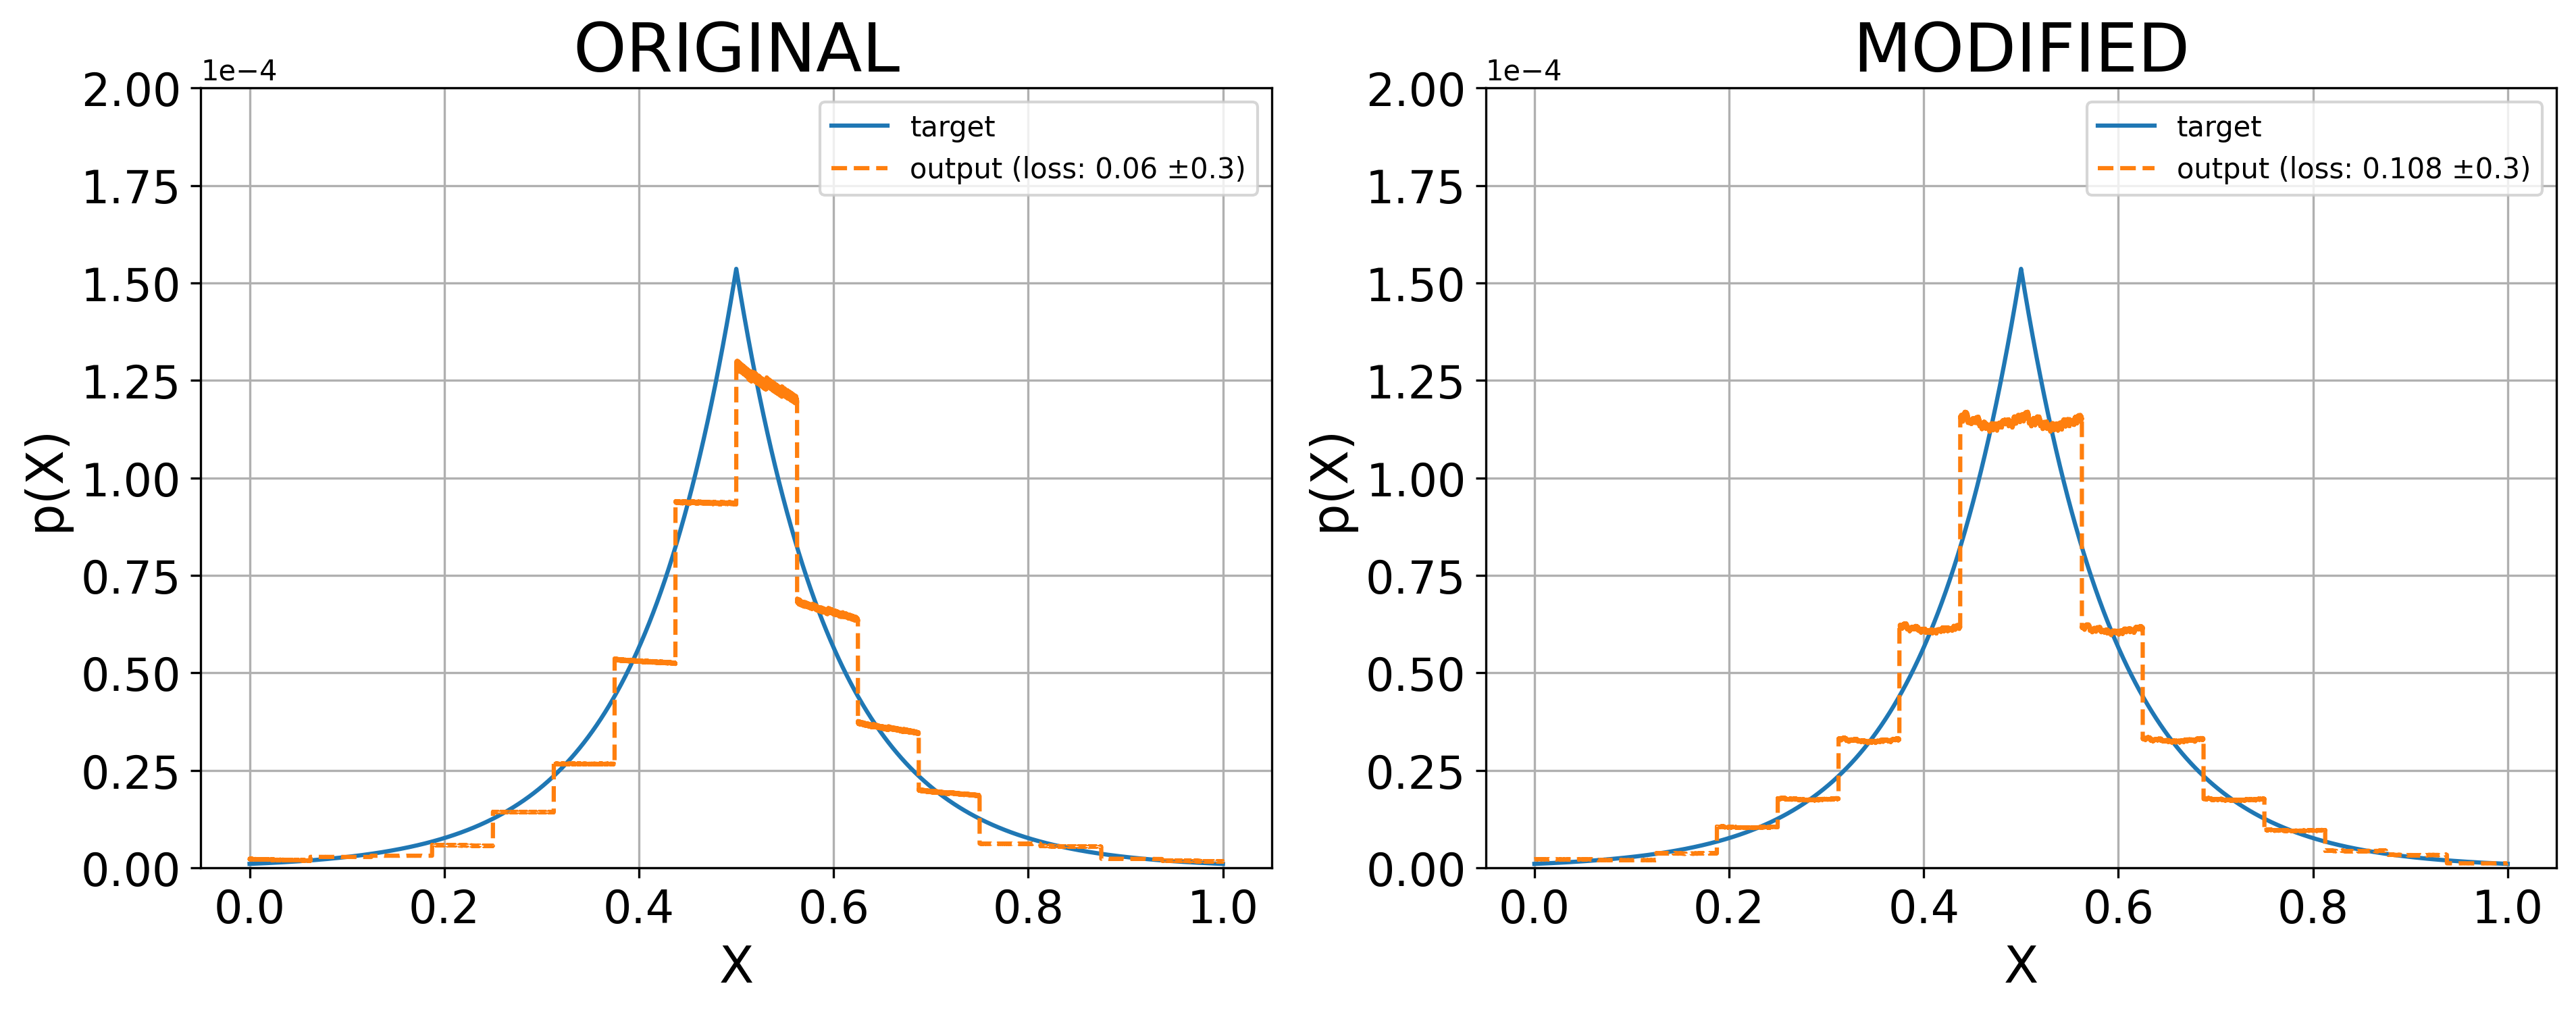

In [48]:
target_state = get_state(num_qubits=n_qubits, state_type=state_type, state_params={"x_points": (0, 1), "loc": 0.5, "scale": 0.2})


x_points = np.linspace(0, 1, 2**n_qubits)

target_freqs = np.abs(target_state)**2

#plt.ticklabel_format(axis="y", style="sci")
fig, axes = plt.subplots(1, 2, dpi=300)
fig.set_figheight(5)
fig.set_figwidth(15)
title_fontsize = 24
labels_fontsize= 18
ticks_fontsize = 16
axes[0].set_title("ORIGINAL", fontsize=title_fontsize)
axes[0].plot(x_points, target_freqs, label="target")
axes[0].plot(x_points, np.abs(sv_mean_original)**2, "--", label=f"output (loss: {round(df_mean_original.loc[n_qubits][eps_value], 3)} ±{round(df_stds_original.loc[n_qubits][eps_value], 2)})")
axes[0].grid()
axes[0].set_xlabel("X", fontsize=labels_fontsize)
axes[0].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[0].tick_params(labelsize=ticks_fontsize)
axes[0].set_ylim([0, 0.0002])
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].legend(loc="best")

axes[1].set_title("MODIFIED", fontsize=title_fontsize)
axes[1].plot(x_points, target_freqs, label="target")
axes[1].plot(x_points, np.abs(sv_mean_modified)**2, "--", label=f"output (loss: {round(df_mean_modified.loc[n_qubits][eps_value], 3)} ±{round(df_stds_modified.loc[n_qubits][eps_value], 2)})")
axes[1].grid()
axes[1].set_xlabel("X", fontsize=labels_fontsize)
axes[1].set_ylabel("p(X)", fontsize=labels_fontsize)
axes[1].tick_params(labelsize=ticks_fontsize)
axes[1].set_ylim([0, 0.0002])
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].legend(loc="best")